In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [313]:
## if loading mat file.
mat=scipy.io.loadmat('/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000129_21648_NetworkTemplates.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Sep 21 11:59:23 2023', '__version__': '1.0', '__globals__': [], 'firingRateNorm': array([[0.19073733],
       [0.20758733],
       [0.22365442],
       ...,
       [0.22084624],
       [0.20602084],
       [0.1901111 ]])}


In [2]:
import os
import glob

# Specify the directory path where you want to search for .mat files
directory_path = '/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/'

# Use glob to find all .mat files in the directory
mat_files = glob.glob(os.path.join(directory_path, '*.mat'))

# mat_files will now contain a list of file paths to all the .mat files in the directory
print("List of .mat files:")
for mat_file in mat_files:
    print(mat_file)


List of .mat files:
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000232_21644_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000222_21609_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000161_21644_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000228_21661_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000136_21625_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000154_21664_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000103_21613_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000140_21612_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000099_21609_NetworkTemplates.mat
/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/Templat

In [155]:
import os

file_path = '/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplateMats/000138_21661_NetworkTemplates.mat'

# Get the base name of the file (including extension)
file_name_with_extension = os.path.basename(file_path)

# Split the file name and extension
file_name, file_extension = os.path.splitext(file_name_with_extension)

# Now, file_name contains the name of the file without the extension
print("File name without extension:", file_name)

File name without extension: 000138_21661_NetworkTemplates


In [158]:
from sklearn.cluster import KMeans
import pickle
def calculate_burst_features(stacked_bursts, threshold=0.5):

    feature_array = np.empty((len(stacked_bursts), 1)) 
    
    for i,burst in enumerate(stacked_bursts):
    
        # Find the peak amplitude and its index
        peak_amplitude = np.max(burst)
        peak_index = np.argmax(burst)
        # Calculate the half-maximum threshold
        half_threshold = threshold * peak_amplitude

        # Search for the left boundary where the amplitude first crosses half-maximum
        left_boundary = np.where(burst[:peak_index] <= half_threshold)[0]
        if len(left_boundary) == 0:
            left_boundary_index = 0
        else:
            left_boundary_index = left_boundary[-1] + 1

        # Search for the right boundary where the amplitude crosses half-maximum again
        right_boundary = np.where(burst[peak_index:] <= half_threshold)[0]
        if len(right_boundary) == 0:
            right_boundary_index = len(burst) - 1
        else:
            right_boundary_index = peak_index + right_boundary[0]

        # Calculate the half-width
        half_width = right_boundary_index - left_boundary_index + 1

        feature_array[i] = [peak_amplitude]
    

    return feature_array




for mat_file in mat_files:

    mat=scipy.io.loadmat(mat_file)
    data = mat['firingRateNorm'] 
    
    burst_start = False
    peak = 0
    peak_list=[]
    burst_start = False
    peak_index_list=[]
    peak_index = 0
    threshold = 3.5
    total = len(data)


    for x in range(1, total-2):
        if data[x] >= threshold and data[x] > data[x-1] and data[x] > data[x+1] and data[x] > peak:
            burst_start = True
            peak = data[x]
            peak_index = x
        if data[x] < 1 and burst_start == True:
            peak_list.append(peak)
            peak_index_list.append(peak_index)
            peak=0
            peak_index = 0
            burst_start = False  
        peak_index_list = [value for value in peak_index_list if value < 0 or value > 50]
        print(peak_index_list)
        #generating a list containing all the bursts/the values representing individual burst in the data starting from the index of the highest peaks.
        list_of_burst = []
        left_bound = 30
        right_bound =30
        for index in peak_index_list:
            individual_burst=np.array(data[index-left_bound:index+right_bound]).flatten()

            #individual_burst.sort()
            list_of_burst.append(individual_burst)

        # #the values were represented as element in Numpy array, which make it impossible to perform PCC. Hence, the following codes extract the values out
        # for i in range(0, len(list_of_burst)):
        #     for x in range(0, len(list_of_burst[0])):
        #         list_of_burst[i][x] = list_of_burst[i][x][0]
        stacked_bursts = np.vstack(list_of_burst)


        

        features = calculate_burst_features(stacked_bursts, threshold=0.5)

        # Assuming features is a NumPy array where each row represents a burst with two columns (half-width, peak)

        # Initialize an empty list to store the WCSS values for different values of K
        wcss = []

        # Define a range of values for K (number of clusters)
        k_values = range(1, 11)  # You can adjust the range as needed

        # Calculate WCSS for each value of K
        for k in k_values:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(features[:,0].reshape(-1,1))
            wcss.append(kmeans.inertia_)
        # Calculate the change in slope between consecutive WCSS values
        slope_changes = [abs(wcss[i] - wcss[i - 1] )for i in range(1, len(wcss))]

        # Find the index with the maximum slope change
        optimal_k_index = slope_changes.index(max(slope_changes)) + 1  # Adding 1 because of zero-based indexing

        # Optimal K is the K value at the inflection point with the maximum slope change
        optimal_k = k_values[optimal_k_index]

        kmeans = KMeans(n_clusters=optimal_k)
        cluster_labels = kmeans.fit_predict(features)
        # print(cluster_labels)
        # Now, cluster_labels contains the cluster assignments for each burst

        # Create a dictionary to store features and their indices for each cluster
        cluster_data = {cluster_id: {'features': [], 'indices': []} for cluster_id in range(optimal_k)}

        # Assign features and their indices to their respective clusters
        for i, label in enumerate(cluster_labels):
            cluster_data[label]['features'].append(features[i])
            cluster_data[label]['indices'].append(i)

        for label in cluster_data.keys():
            cluster_data[label]['template'] = np.mean(stacked_bursts[cluster_data[label]['indices'],:])
        # Access features and indices for a specific cluster (e.g., cluster 0)

        file_name_with_extension = os.path.basename(mat_file)

        # Split the file name and extension
        file_name, file_extension = os.path.splitext(file_name_with_extension)
        pickle.dump(cluster_data,f'./PickelFile/{file_name}.pkl')

[]


ValueError: need at least one array to concatenate

In [322]:
len(data)

14996

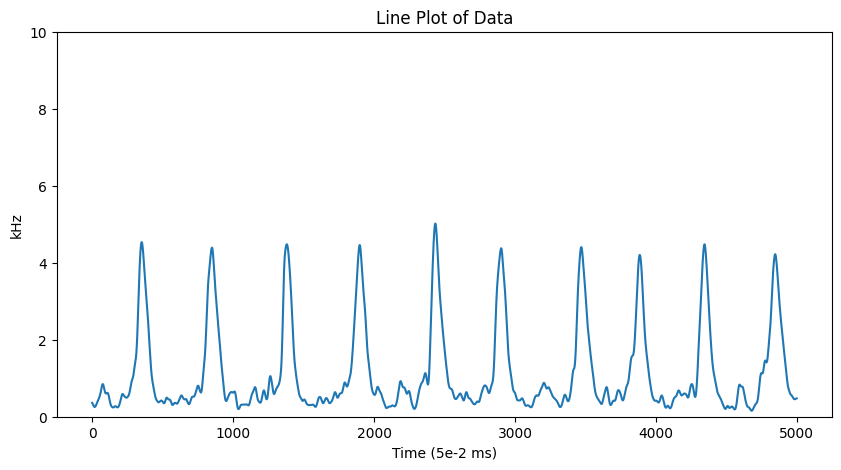

dict_keys(['__header__', '__version__', '__globals__', 'firingRateNorm'])
14996


In [318]:
data = mat['firingRateNorm']  # visualizing the data
plt.figure(figsize=(10, 5))
plt.plot(data[4600:9600])
plt.xlabel('Time (5e-2 ms)')
plt.ylabel('kHz')
plt.title('Line Plot of Data')
plt.ylim([0 ,10])
plt.savefig('/home/mmp/Documents/Images_25sep/templatematching_signal_control.pdf',format='pdf')
plt.show()
print(mat.keys())
total = len(data)
print(total)

In [319]:
#find the index of the highest point in each burst
burst_start = False
peak = 0
peak_list=[]
burst_start = False
peak_index_list=[]
peak_index = 0
threshold = 3


for x in range(1, total-2):
    if data[x] >= threshold and data[x] > data[x-1] and data[x] > data[x+1] and data[x] > peak:
        burst_start = True
        peak = data[x]
        peak_index = x
    if data[x] < 1 and burst_start == True:
        peak_list.append(peak)
        peak_index_list.append(peak_index)
        peak=0
        peak_index = 0
        burst_start = False  
peak_index_list = [value for value in peak_index_list if value < 0 or value > 50]
print(peak_index_list)

#skipping a little in the beginingn to get correct shape of the first peak


[285, 766, 1133, 1879, 2374, 2878, 3409, 3911, 4382, 4952, 5450, 5981, 6499, 7035, 7502, 8071, 8486, 8945, 9446, 10061, 10536, 10969, 11438, 12096, 12560, 13067, 13749, 14285, 14758]


In [320]:
#generating a list containing all the bursts/the values representing individual burst in the data starting from the index of the highest peaks.
list_of_burst = []
left_bound = 75
right_bound =75
for index in peak_index_list:
    individual_burst=np.array(data[index-left_bound:index+right_bound]).flatten()

    #individual_burst.sort()
    list_of_burst.append(individual_burst)

# #the values were represented as element in Numpy array, which make it impossible to perform PCC. Hence, the following codes extract the values out
# for i in range(0, len(list_of_burst)):
#     for x in range(0, len(list_of_burst[0])):
#         list_of_burst[i][x] = list_of_burst[i][x][0]
stacked_bursts = np.vstack(list_of_burst)
print(stacked_bursts.shape)

(29, 150)


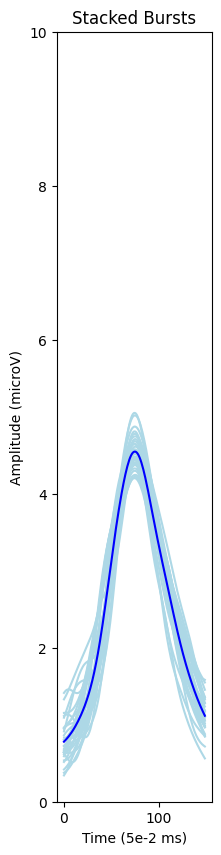

In [321]:
import matplotlib.pyplot as plt

# Assuming you have imported necessary libraries, and you have 'stacked_bursts' as a 2D NumPy array

# Plot all rows (bursts) on top of each other
plt.figure(figsize=(2,10))  # Adjust the figure size as needed
plt.clf()
for row in stacked_bursts:
    plt.plot(row,c='lightblue')
template = np.mean(stacked_bursts,axis=0)
plt.plot(template,c='blue')
plt.ylim([0,10])
plt.xlabel('Time (5e-2 ms)')
plt.ylabel('Amplitude (microV)')
plt.title('Stacked Bursts')
plt.savefig('/home/mmp/Documents/Images_25sep/templatematching_aggregate_control.pdf',format='pdf')
plt.show()

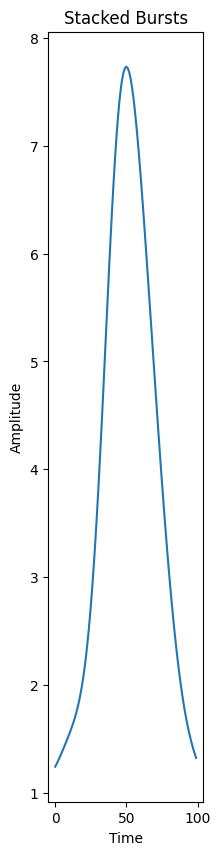

<Figure size 640x480 with 0 Axes>

In [126]:
template = np.mean(stacked_bursts,axis=0)
plt.figure(figsize=(2, 10)) 
plt.plot(template)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Stacked Bursts')

plt.show()
plt.clf()

In [197]:
#whole routine for the biggest template.
import pandas as pd
import pickle
dataframe = pd.DataFrame(columns=["Filename","Stacked Bursts","Template"])
error_l=[]
for mat_file in mat_files:

    mat=scipy.io.loadmat(mat_file)
    data = mat['firingRateNorm'] 
    total = len(data)
    file_name_with_extension = os.path.basename(mat_file)

    # Split the file name and extension
    file_name, file_extension = os.path.splitext(file_name_with_extension)
    print(file_name)
   #find the index of the highest point in each burst
    burst_start = False
    peak = 0
    peak_list=[]
    burst_start = False
    peak_index_list=[]
    peak_index = 0
    threshold = 3.5
    

    for x in range(1, total-2):
        if data[x] >= threshold and data[x] > data[x-1] and data[x] > data[x+1] and data[x] > peak:
            burst_start = True
            peak = data[x]
            peak_index = x
        if data[x] < 1 and burst_start == True:
            peak_list.append(peak)
            peak_index_list.append(peak_index)
            peak=0
            peak_index = 0
            burst_start = False  
    peak_index_list = [value for value in peak_index_list if value < 0 or value > 50]
    if not peak_index_list:

        error_l.append(file_name)
        continue
        
    #generating a list containing all the bursts/the values representing individual burst in the data starting from the index of the highest peaks.
    list_of_burst = []
    left_bound = 50
    right_bound =50
    for index in peak_index_list:
        individual_burst=np.array(data[index-left_bound:index+right_bound]).flatten()

        #individual_burst.sort()
        list_of_burst.append(individual_burst)

        # #the values were represented as element in Numpy array, which make it impossible to perform PCC. Hence, the following codes extract the values out
        # for i in range(0, len(list_of_burst)):
        #     for x in range(0, len(list_of_burst[0])):
        #         list_of_burst[i][x] = list_of_burst[i][x][0]
    stacked_bursts = np.vstack(list_of_burst)

    template = np.mean(stacked_bursts,axis=0)
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/StackedBurstPickelFile/{file_name}.pkl",'wb') as f1:
        pickle.dump(stacked_bursts,f1)
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplatesPickelFile/{file_name}.pkl",'wb') as f2:
        pickle.dump(template,f2)
    new_data = {"Filename": file_name, "Stacked Bursts": stacked_bursts, "Template": template}
    dataframe = pd.concat([dataframe, pd.DataFrame([new_data])], ignore_index=True)



# Save the DataFrame to Excel
dataframe.to_excel("./template_outputs3.xlsx", index=False, engine="openpyxl")


000232_21644_NetworkTemplates
000222_21609_NetworkTemplates
000161_21644_NetworkTemplates
000228_21661_NetworkTemplates
000136_21625_NetworkTemplates
000154_21664_NetworkTemplates
000103_21613_NetworkTemplates
000140_21612_NetworkTemplates
000099_21609_NetworkTemplates
000146_21648_NetworkTemplates
000224_21664_NetworkTemplates
000150_21670_NetworkTemplates
000148_21661_NetworkTemplates
000089_21625_NetworkTemplates
000091_21648_NetworkTemplates
000125_21670_NetworkTemplates
000087_21670_NetworkTemplates
000156_21625_NetworkTemplates
000123_21609_NetworkTemplates
000105_21644_NetworkTemplates
000109_21613_NetworkTemplates
000111_21644_NetworkTemplates
000215_21625_NetworkTemplates
000093_21661_NetworkTemplates
000101_21664_NetworkTemplates
000117_21661_NetworkTemplates
000226_21648_NetworkTemplates
000121_21664_NetworkTemplates
000119_21648_NetworkTemplates
000129_21648_NetworkTemplates
000159_21613_NetworkTemplates
000218_21670_NetworkTemplates
000115_21625_NetworkTemplates
000230_216

In [37]:
print(error_l)

['000232_21644_NetworkTemplates', '000140_21612_NetworkTemplates', '000089_21625_NetworkTemplates']


In [99]:
print(error_l)

['000232_21644_NetworkTemplates', '000140_21612_NetworkTemplates', '000089_21625_NetworkTemplates']


In [100]:
df1 = pd.read_excel("/mnt/disk15tb/mmpatil/MEA_Analysis/TemplateMatching/template_outputs.xlsx")

In [102]:
# Define a function to assign values to the "line" column based on the "Chip_ID" values
def assign_line(chip_id):
    if chip_id in [21670, 21648, 21609, 21613]:
        return 'syngap control'
    elif chip_id in [21625, 21661, 21664, 21644]:
        return 'Syngap'
    else:
        return None

# Apply the function to create the "line" column
df1['line'] = df1['chip'].apply(assign_line)

In [103]:
df1.head(8)

,Unnamed: 0,Filename,Stacked Bursts,Template,DIV,chip,line
0,0,000222_21609_NetworkTemplates,[[0.99438312 1.08838888 1.19630152 ... 2.92374...,[1.26062699 1.34825061 1.44440121 1.54928095 1...,101,21609,syngap control
1,1,000161_21644_NetworkTemplates,[[1.9611316 2.02672095 2.10406646 ... 3.95832...,[1.65395698 1.75807145 1.87263858 1.99962257 2...,96,21644,Syngap
2,2,000228_21661_NetworkTemplates,[[1.8402909 1.92787001 2.01309861 2.09426237 ...,[1.8402909 1.92787001 2.01309861 2.09426237 2...,101,21661,Syngap
3,3,000136_21625_NetworkTemplates,[[1.30128867 1.3491664 1.40310055 1.46455704 ...,[1.31038082 1.37085072 1.43392491 1.50228138 1...,89,21625,Syngap
4,4,000154_21664_NetworkTemplates,[[0.7418993 0.73568096 0.74095609 ... 1.73753...,[1.17821682 1.20267892 1.23607757 1.28072028 1...,96,21664,Syngap
5,5,000103_21613_NetworkTemplates,[[1.79737909 1.95905976 2.1311393 ... 4.70322...,[2.07499367 2.21568193 2.36421471 2.52081108 2...,84,21613,syngap control
6,6,000099_21609_NetworkTemplates,[[1.60241866 1.68329402 1.77163644 ... 3.47200...,[1.82154946 1.88215309 1.94836992 2.02182548 2...,84,21609,syngap control
7,7,000146_21648_NetworkTemplates,[[1.68654563 1.7678553 1.8532181 ... 2.61778...,[1.44253508 1.50217379 1.56493317 1.63102618 1...,96,21648,syngap control


In [186]:
df2 = pd.read_excel("/mnt/disk15tb/mmpatil/MEA_Analysis/TemplateMatching/template_outputs3.xlsx")

In [187]:
df2.head()

,Filename,Stacked Bursts,Template
0,000222_21609_NetworkTemplates,[[0.45234466 0.45936815 0.46524731 ... 1.54839...,[0.61343212 0.62181516 0.63086935 0.64123468 0...
1,000161_21644_NetworkTemplates,[[1.14734832 1.20479232 1.26148431 ... 1.73253...,[0.65177802 0.67811095 0.70587687 0.7352316 0...
2,000228_21661_NetworkTemplates,[[0.56242472 0.57406623 0.58923361 0.61241983 ...,[0.56242472 0.57406623 0.58923361 0.61241983 0...
3,000136_21625_NetworkTemplates,[[0.6005309 0.63336424 0.66715807 0.70204374 ...,[0.739896 0.75477964 0.76856698 0.78244659 0...
4,000154_21664_NetworkTemplates,[[1.51277036 1.49676299 1.47495943 ... 0.38910...,[1.12353803 1.13370994 1.14221275 1.14926882 1...


In [188]:
df2['DIV']=df1['DIV']
df2['chip'] = df1['chip']
df2['line']=df1['line']

In [189]:
sorted_df = df2.sort_values(by='DIV')
display(sorted_df)

,Filename,Stacked Bursts,Template,DIV,chip,line
16,000105_21644_NetworkTemplates,[[1.55716778 1.61029064 1.66351779 ... 1.18371...,[1.08541411 1.10436279 1.12461705 1.14619046 1...,84,21644,Syngap
5,000103_21613_NetworkTemplates,[[0.58453784 0.58388881 0.5857217 ... 2.83711...,[0.6991273 0.72231986 0.74825211 0.77728675 0...,84,21613,syngap control
6,000099_21609_NetworkTemplates,[[0.88421591 0.90285723 0.92169832 ... 1.69360...,[1.05169561 1.08185057 1.11262743 1.14424312 1...,84,21609,syngap control
21,000101_21664_NetworkTemplates,[[1.74465438 1.77824427 1.8062515 1.82788049 ...,[1.24128975 1.27419083 1.30633369 1.33740203 1...,84,21664,Syngap
20,000093_21661_NetworkTemplates,[[1.22032918 1.23645426 1.25204685 ... 1.17951...,[1.24080195 1.26341314 1.28659993 1.31026458 1...,84,21661,Syngap
11,000091_21648_NetworkTemplates,[[1.14431334 1.18702523 1.23339635 ... 1.55301...,[1.21905901 1.24728183 1.27691475 1.30804304 1...,84,21648,syngap control
13,000087_21670_NetworkTemplates,[[1.29039636 1.2924227 1.29438976 ... 2.26168...,[0.66012801 0.68061872 0.70211907 0.72492602 0...,84,21670,syngap control
31,000113_21670_NetworkTemplates,[[0.47613212 0.50067745 0.52616663 ... 1.58861...,[0.44535451 0.45772915 0.47205749 0.48851495 0...,88,21670,syngap control
29,000115_21625_NetworkTemplates,[[0.161348 0.17006349 0.17931069 0.18930161 ...,[0.21601379 0.22374964 0.23285798 0.24332529 0...,88,21625,Syngap
25,000119_21648_NetworkTemplates,[[1.19599006 1.21200868 1.2275352 ... 2.35926...,[1.16776919 1.19358921 1.22128195 1.25067354 1...,88,21648,syngap control


In [214]:
condtion1=(sorted_df['DIV']==88)
condition2=(sorted_df['line']=='syngap control')

filtered_df = sorted_df[condtion1&condition2]



,Filename,Stacked Bursts,Template,DIV,chip,line
31,000113_21670_NetworkTemplates,[[0.47613212 0.50067745 0.52616663 ... 1.58861...,[0.44535451 0.45772915 0.47205749 0.48851495 0...,88,21670,syngap control
25,000119_21648_NetworkTemplates,[[1.19599006 1.21200868 1.2275352 ... 2.35926...,[1.16776919 1.19358921 1.22128195 1.25067354 1...,88,21648,syngap control
17,000109_21613_NetworkTemplates,[[0.54430377 0.56825536 0.59390111 ... 2.61936...,[0.56919629 0.58624841 0.60480755 0.62520244 0...,88,21613,syngap control
15,000123_21609_NetworkTemplates,[[0.27486418 0.27214167 0.27177553 ... 1.45451...,[0.6153317 0.6339447 0.65390427 0.67584302 0...,88,21609,syngap control


In [215]:
template_list =[]
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplatesPickelFile/{file_name}.pkl",'rb') as f4:
        template_array= pickle.load(f4)
    template_list.append(template_array)
template_array = np.array(template_list)

mean_template_wt = np.mean(template_array,axis=0)


In [216]:
stacked_bursts_array = []
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/StackedBurstPickelFile/{file_name}.pkl",'rb') as f5:
        stacked_bursts_here = pickle.load(f5)
        # if stacked_bursts_array is None:
        #     stacked_bursts_array  = stacked_bursts_here
        # else :
        stacked_bursts_array.append(stacked_bursts_here)
stacked_arry_wt = np.vstack(stacked_bursts_array)
stacked_arry_wt.shape

(97, 100)

In [217]:
pcc_scores_wt_wt= [np.corrcoef(mean_template_wt,burst)[0,1] for burst in stacked_arry_wt ]
print(pcc_scores_wt_wt)


[0.9891603646775236, 0.9850398647169305, 0.989348116969888, 0.9680397700255662, 0.9735908816744442, 0.9961685304746855, 0.9904230528787422, 0.9748864443352615, 0.9840690966129179, 0.9843148846655968, 0.9120814274732258, 0.9930758951155009, 0.9426607328992505, 0.9991694164620591, 0.9912528018290491, 0.9134400149164129, 0.9976383916868665, 0.9805191422341749, 0.9655906068130864, 0.9556790273357737, 0.9164734861446139, 0.9578639585507033, 0.982588390204035, 0.9692986457951902, 0.9982492904215956, 0.9992184989674024, 0.9921028664566759, 0.9535905631653536, 0.9719450333640157, 0.9966180798006777, 0.9774234351488851, 0.9773561585913996, 0.9935417598280012, 0.9969937765730608, 0.9810682756297052, 0.9935161431129444, 0.9942299551117295, 0.9641580870428987, 0.9824183333372781, 0.9923064531325065, 0.995434213087838, 0.9877610609525732, 0.9920727492919755, 0.9920096724843084, 0.9819831481333424, 0.9927646836987374, 0.993494941206905, 0.992619094404073, 0.9775145353497853, 0.9978501997982699, 0.99

In [219]:
condtion1=(sorted_df['DIV']==88)
condition2=(sorted_df['line']=='Syngap')

filtered_df = sorted_df[condtion1&condition2]
template_list =[]
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplatesPickelFile/{file_name}.pkl",'rb') as f6:
        template_array= pickle.load(f6)
    template_list.append(template_array)
template_array = np.array(template_list)

mean_template_syngap = np.mean(template_array,axis=0)

stacked_bursts_array = []
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/StackedBurstPickelFile/{file_name}.pkl",'rb') as f7:
        stacked_bursts_here = pickle.load(f7)
        # if stacked_bursts_array is None:
        #     stacked_bursts_array  = stacked_bursts_here
        # else :
        stacked_bursts_array.append(stacked_bursts_here)
stacked_arry_syngap = np.vstack(stacked_bursts_array)
print(stacked_arry_syngap.shape)
pcc_scores_wt_syngap= [np.corrcoef(mean_template_wt,burst)[0,1] for burst in stacked_arry_syngap ]
print(pcc_scores_wt_syngap)

(74, 100)
[0.9183722718402652, 0.9510322110105788, 0.9110847943332021, 0.7660968583446023, 0.8485270841902331, 0.9282624893383581, 0.908921325816993, 0.8099526016015473, 0.9213766549869621, 0.9279268936942883, 0.8449981159714853, 0.8276859015798218, 0.874590967712622, 0.8715593436288375, 0.932911482453818, 0.8086047401289786, 0.8899295514174732, 0.7651004642101129, 0.8892473779417586, 0.9327318002930962, 0.7866995935591281, 0.8539638111831177, 0.7761520319645415, 0.7854518228056737, 0.8689222247859582, 0.8388308851088727, 0.9151686022161258, 0.890047656624234, 0.9154801259633387, 0.9381101444558801, 0.8227666568451019, 0.8392254016637788, 0.9141559620995108, 0.8281408751782013, 0.9135541945869788, 0.9031438959380464, 0.9484223939921789, 0.969690931766659, 0.9096198006484127, 0.9125835646483138, 0.9844202328311312, 0.9602985396889662, 0.9567677484852751, 0.8778835486942317, 0.8643392359173665, 0.879117940463591, 0.911182645272319, 0.8664355991759075, 0.9767109285370756, 0.9561042655788,

In [237]:
condtion1=(sorted_df['DIV']==101)
condition2=(sorted_df['line']=='syngap control')
f6=None
f7=None
filtered_df = sorted_df[condtion1&condition2]
template_list =[]
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplatesPickelFile/{file_name}.pkl",'rb') as f6:
        template_array= pickle.load(f6)
    template_list.append(template_array)
template_array = np.array(template_list)

mean_template_wt_101 = np.mean(template_array,axis=0)

stacked_bursts_array = []
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/StackedBurstPickelFile/{file_name}.pkl",'rb') as f7:
        stacked_bursts_here = pickle.load(f7)
        # if stacked_bursts_array is None:
        #     stacked_bursts_array  = stacked_bursts_here
        # else :
        stacked_bursts_array.append(stacked_bursts_here)
stacked_arry_control_div101 = np.vstack(stacked_bursts_array)
print(stacked_arry_control_div101.shape)
pcc_scores_wt_wt_101= [np.corrcoef(mean_template_wt_101,burst)[0,1] for burst in stacked_arry_control_div101 ]
print(pcc_scores_wt_wt_101)

(126, 100)
[0.9923015239989976, 0.9881463199186176, 0.9761052223216163, 0.9975136168296933, 0.9957396330470123, 0.9855065147699796, 0.9869919216349963, 0.9936979102660485, 0.987686182625997, 0.9920416428073524, 0.9981758749783451, 0.9985699409704715, 0.9924695673984292, 0.9989324385989035, 0.998934154164325, 0.9902789354475258, 0.9827253952847566, 0.9921192976954359, 0.9937430647719148, 0.9842979244779334, 0.987380710250301, 0.9964613508139724, 0.9940970248691623, 0.9766708834620804, 0.998217062758406, 0.991436769172443, 0.9737818149247527, 0.9885460257303945, 0.9967354406159538, 0.9926679195158976, 0.9940487696406056, 0.995896674129531, 0.9965557440925855, 0.9814812247975561, 0.9955983869422713, 0.9951894367136557, 0.9966350547733052, 0.988643488193201, 0.9888091790817707, 0.9806136361976364, 0.9958616036328272, 0.9897534680703949, 0.9906421402134994, 0.9757167448993349, 0.9963824819552225, 0.9987762075309318, 0.9922510476881014, 0.9963578679431147, 0.9952391077274589, 0.9943921899812

In [238]:
condtion1=(sorted_df['DIV']==101)
condition2=(sorted_df['line']=='Syngap')
f6=None
f7=None
filtered_df = sorted_df[condtion1&condition2]
template_list =[]
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/TemplatesPickelFile/{file_name}.pkl",'rb') as f6:
        template_array= pickle.load(f6)
    template_list.append(template_array)
template_array = np.array(template_list)

mean_template_syngap_101 = np.mean(template_array,axis=0)

stacked_bursts_array = []
for i in range(len(filtered_df)):
    file_name = filtered_df['Filename'].iloc[i]
    with open(f"/home/mmp/disktb/mmpatil/MEA_Analysis/TemplateMatching/StackedBurstPickelFile/{file_name}.pkl",'rb') as f7:
        stacked_bursts_here = pickle.load(f7)
        # if stacked_bursts_array is None:
        #     stacked_bursts_array  = stacked_bursts_here
        # else :
        stacked_bursts_array.append(stacked_bursts_here)
stacked_arry_syngap_div101 = np.vstack(stacked_bursts_array)
print(stacked_arry_syngap_div101.shape)
pcc_scores_wt_syngap_101= [np.corrcoef(mean_template_wt_101,burst)[0,1] for burst in stacked_arry_syngap_div101 ]
print(pcc_scores_wt_syngap_101)

(35, 100)
[0.9794510804493394, 0.9094639554706916, 0.9021577147098062, 0.9494372439412682, 0.9460523015888743, 0.9641255789399497, 0.9700149406934263, 0.9890880235866509, 0.9445640390329595, 0.9595627128076151, 0.8938768523192172, 0.9618046878223256, 0.9592151288296358, 0.9520836364367115, 0.9236987681939575, 0.8377800638919278, 0.8899355120096567, 0.8701512041875379, 0.8848921794146082, 0.9700159811889749, 0.8344327736134435, 0.8969319017898827, 0.8690110797272874, 0.9170636544285535, 0.8778662209494761, 0.8164260910306667, 0.9088066706880272, 0.9581786236395015, 0.9192182202282367, 0.9581212512445568, 0.938480681735297, 0.8581196816978467, 0.7704944251592404, 0.8127005109731019, 0.9517283025665748]


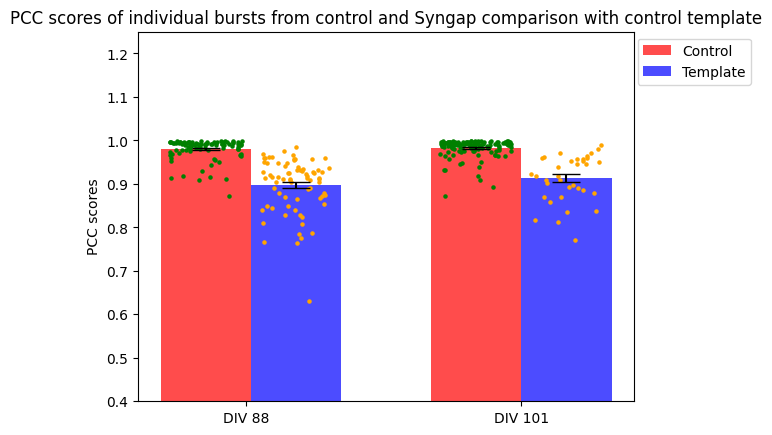

In [312]:
import numpy as np
import matplotlib.pyplot as plt
import random


total_div =1
# Convert data lists to NumPy arrays
group1_data = np.array(pcc_scores_wt_wt)
group2_data = np.array(pcc_scores_wt_syngap)

# Calculate means and standard errors of means (SEM)
mean1 = np.mean(group1_data)
sem1 = np.std(group1_data) / np.sqrt(len(group1_data))
mean2 = np.mean(group2_data)
sem2 = np.std(group2_data) / np.sqrt(len(group2_data))

# Convert data lists to NumPy arrays
group3_data = np.array(pcc_scores_wt_wt_101)
group4_data = np.array(pcc_scores_wt_syngap_101)

# Calculate means and standard errors of means (SEM)
mean3 = np.mean(group3_data)
sem3 = np.std(group3_data) / np.sqrt(len(group3_data))
mean4 = np.mean(group4_data)
sem4 = np.std(group4_data) / np.sqrt(len(group4_data))

# Create a bar graph with two-color bars and jittered data points along the x-axis
bar_width = 0.05  # Width of each bar

x_wt = 1
x_het = 1.05



  # X-axis positions for two groups
opacity = 0.7
jitter = 0.02  # Amount of jitter along the x-axis



# Create bars for Group 1 with two colors
plt.bar(x_wt, mean1, bar_width, alpha=opacity, color='red', yerr=sem1, capsize=10,ecolor='black',label='Control')
plt.bar(x_het, mean2, bar_width, alpha=opacity, color='blue',  yerr=sem2,capsize=10,ecolor='black',label='Template')

# Scatter the data points for both groups along the x-axis
plt.scatter(np.repeat(x_wt, len(group1_data)) +np.random.uniform(-jitter,jitter,len(group1_data)), group1_data, marker='o',s=5,color='green')
plt.scatter(np.repeat(x_het, len(group2_data))+np.random.uniform(-jitter,jitter,len(group2_data)), group2_data, marker='o',s=5,color='orange')

# Create bars for Group 1 with two colors
plt.bar(x_wt+0.15, mean3, bar_width, alpha=opacity, color='red', yerr=sem3, capsize=10,ecolor='black')
plt.bar(x_het+0.15, mean4, bar_width, alpha=opacity, color='blue',  yerr=sem4,capsize=10,ecolor='black')

# Scatter the data points for both groups along the x-axis
plt.scatter(np.repeat(x_wt+0.15, len(group3_data)) +np.random.uniform(-jitter,jitter,len(group3_data)), group3_data, marker='o',s=5,color='green')
plt.scatter(np.repeat(x_het+0.15, len(group4_data))+np.random.uniform(-jitter,jitter,len(group4_data)), group4_data, marker='o',s=5,color='orange')

# Customize the plot

plt.ylabel('PCC scores')
plt.title('PCC scores of individual bursts from control and Syngap comparison with control template')
plt.legend()
plt.xticks([1.0225,1.175],['DIV 88','DIV 101'])  # Remove x-axis ticks
plt.ylim([0.4,1.25])

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
# Show the plot

plt.savefig("/home/mmp/Documents/Images_25sep/templatematching_plot.pdf",format='pdf' ,bbox_inches='tight')


In [248]:
print(mean1, sem1)
print(mean2, sem2)
print(mean3, sem3)
print(mean4, sem4)

0.9812458371688684 0.0023880379707717845
0.8973973837218733 0.007226162225125225
0.9829899955079079 0.0018419587697951908
0.9127129055710522 0.008988845895214266


In [173]:
template_list =[]
for i in range(len(extracted_templates)):
    values_str = extracted_templates.iloc[i].strip('[]').split()
    # Convert the string values to floats
    values_float = [float(val) for val in values_str]
    template_list.append(values_float)

template_array = np.array(template_list)

mean_template = np.mean(template_array,axis=0)

print(mean_template)

[0.69941292 0.71787787 0.73801282 0.76005849 0.78424088 0.81077764
 0.8399014  0.87198312 0.90727596 0.94614171 0.98880557 1.03570965
 1.08724229 1.14375796 1.20559919 1.27301037 1.34647163 1.4262943
 1.51283146 1.60618048 1.70656476 1.81410361 1.92885198 2.05068443
 2.17939909 2.31461016 2.45591482 2.60260793 2.75399152 2.90922245
 3.06722178 3.22693323 3.38716141 3.54663064 3.7040201  3.8581259
 4.00750229 4.15098246 4.28725801 4.41527284 4.53400193 4.6427649
 4.74067609 4.82720429 4.90196994 4.9648166  5.01565174 5.0546618
 5.08199609 5.09815855 5.10359407 5.09893293 5.0848241  5.06214477
 5.0315601  4.99403066 4.95015615 4.90078589 4.84654629 4.7882929
 4.72643962 4.66158272 4.59424452 4.52476604 4.45361764 4.38080259
 4.3066891  4.23140436 4.15518229 4.07796551 3.99995753 3.92104806
 3.84141542 3.76108272 3.68014054 3.59859106 3.51668624 3.43436773
 3.35181237 3.26923246 3.18679355 3.10463553 3.02297079 2.94203478
 2.86195419 2.78300614 2.70536054 2.62918269 2.55451319 2.48164274


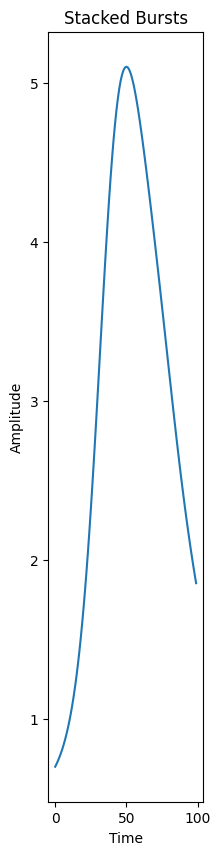

In [174]:
plt.figure(figsize=(2, 10)) 
plt.plot(mean_template)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Stacked Bursts')

plt.show()

In [175]:
extracted_bursts = filtered_df['Stacked Bursts'].str.replace('\n', '')

In [177]:
extracted_bursts.iloc[0]

'[[0.47613212 0.50067745 0.52616663 ... 1.5886198  1.52691248 1.46659206] [0.59402887 0.61821148 0.64392679 ... 1.74584332 1.68953781 1.63262709] [0.6686465  0.68204741 0.6972058  ... 1.54553606 1.48494743 1.42560207] ... [0.34383065 0.34440903 0.34518788 ... 2.04121864 1.97566019 1.91124932] [0.47795573 0.49329529 0.51026643 ... 1.79958971 1.75752267 1.71785425] [0.33529819 0.33928724 0.34560304 ... 1.67939188 1.62059676 1.56590342]]'

In [178]:
extracted_bursts.iloc[0].split(']')

    

['[[0.47613212 0.50067745 0.52616663 ... 1.5886198  1.52691248 1.46659206',
 ' [0.59402887 0.61821148 0.64392679 ... 1.74584332 1.68953781 1.63262709',
 ' [0.6686465  0.68204741 0.6972058  ... 1.54553606 1.48494743 1.42560207',
 ' ... [0.34383065 0.34440903 0.34518788 ... 2.04121864 1.97566019 1.91124932',
 ' [0.47795573 0.49329529 0.51026643 ... 1.79958971 1.75752267 1.71785425',
 ' [0.33529819 0.33928724 0.34560304 ... 1.67939188 1.62059676 1.56590342',
 '',
 '']

In [183]:
import ast

# Your string containing the list of lists as a string
input_str = '[[0.47613212 0.50067745 0.52616663 1.5886198  1.52691248 1.46659206] [0.59402887 0.61821148 0.64392679 1.74584332 1.68953781 1.63262709] [0.6686465  0.68204741 0.6972058 1.54553606 1.48494743 1.42560207]]'

# Add commas between the elements within the inner lists
input_str = input_str.replace(']', '],')
input_str =  input_str[:-3]+']'  # Remove the trailing comma

# Use ast.literal_eval to safely evaluate the string as a list of lists
list_of_lists = ast.literal_eval(input_str)

print(list_of_lists)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [146]:
import re



# Use regular expressions to extract the numeric values
numeric_values = re.findall(r'[-+]?\d*\.\d+|\d+', extracted_bursts.iloc[0])

# Convert the extracted numeric values to a list of lists of floats
list_of_lists_float = []

# Specify the number of columns in each sublist
num_columns = 10  # Adjust this number as per your data

# Split the numeric values into sublists
for i in range(0, len(numeric_values), num_columns):
    sublist = [float(val) for val in numeric_values[i:i+num_columns]]
    list_of_lists_float.append(sublist)

In [147]:
list_of_lists_float

[[0.47613212,
  0.50067745,
  0.52616663,
  1.5886198,
  1.52691248,
  1.46659206,
  0.59402887,
  0.61821148,
  0.64392679,
  1.74584332],
 [1.68953781,
  1.63262709,
  0.6686465,
  0.68204741,
  0.6972058,
  1.54553606,
  1.48494743,
  1.42560207,
  0.34383065,
  0.34440903],
 [0.34518788,
  2.04121864,
  1.97566019,
  1.91124932,
  0.47795573,
  0.49329529,
  0.51026643,
  1.79958971,
  1.75752267,
  1.71785425],
 [0.33529819, 0.33928724, 0.34560304, 1.67939188, 1.62059676, 1.56590342]]

In [140]:
 #Convert the string format to a list of lists with float values
list_of_lists_float = [[float(val) for val in eval(inner_list)] for inner_list in extracted_bursts.iloc[0]]
list_of_lists_float

SyntaxError: '[' was never closed (<string>, line 1)

In [ ]:
for i in range(len(extracted_bursts)):
    

In [90]:
values_str = extracted_templates.iloc[0].strip('[]').split()

# Convert the string values to floats
values_float = [float(val) for val in values_str]

In [91]:
values_float

[1.43187113,
 1.5410095,
 1.65603168,
 1.77628281,
 1.90147803,
 2.030675,
 2.16320597,
 2.29826386,
 2.43479813,
 2.57182331,
 2.70823621,
 2.84299057,
 2.97500275,
 3.10308653,
 3.22630391,
 3.34371084,
 3.45435551,
 3.55774289,
 3.65289322,
 3.73971635,
 3.81788461,
 3.88728868,
 3.94780265,
 3.99963329,
 4.04307855,
 4.07852409,
 4.10634017,
 4.12706138,
 4.14090619,
 4.14854184,
 4.15037762,
 4.14679669,
 4.1383011,
 4.12510592,
 4.10767272,
 4.08621031,
 4.06089186,
 4.03210562,
 3.99978295,
 3.96451294,
 3.9263761,
 3.88524345,
 3.84155062,
 3.79522148,
 3.74657007,
 3.69572734,
 3.64281866,
 3.58792184,
 3.5311957,
 3.47267972,
 3.41267455,
 3.35122442,
 3.28864853,
 3.22499829,
 3.16060781,
 3.09553778,
 3.03012627,
 2.96454005,
 2.8989067,
 2.83343597]

In [82]:
import ast
val = ast.literal_eval(extracted_templates.iloc[2])
val

SyntaxError: invalid syntax (<unknown>, line 1)

In [147]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def calculate_burst_features(stacked_bursts, threshold=0.5):

    feature_array = np.empty((len(stacked_bursts), 1)) 
    
    for i,burst in enumerate(stacked_bursts):
    
        # Find the peak amplitude and its index
        peak_amplitude = np.max(burst)
        peak_index = np.argmax(burst)
        # Calculate the half-maximum threshold
        half_threshold = threshold * peak_amplitude

        # Search for the left boundary where the amplitude first crosses half-maximum
        left_boundary = np.where(burst[:peak_index] <= half_threshold)[0]
        if len(left_boundary) == 0:
            left_boundary_index = 0
        else:
            left_boundary_index = left_boundary[-1] + 1

        # Search for the right boundary where the amplitude crosses half-maximum again
        right_boundary = np.where(burst[peak_index:] <= half_threshold)[0]
        if len(right_boundary) == 0:
            right_boundary_index = len(burst) - 1
        else:
            right_boundary_index = peak_index + right_boundary[0]

        # Calculate the half-width
        half_width = right_boundary_index - left_boundary_index + 1

        feature_array[i] = [peak_amplitude]
    

    return feature_array

# Example usage:

features = calculate_burst_features(stacked_bursts, threshold=0.5)











In [149]:
print(features)

[[2.09146603]
 [2.20430979]
 [1.52698149]
 [7.99709681]
 [1.85646429]
 [2.01170515]
 [8.57873756]
 [1.97455043]
 [2.14095958]
 [8.21110706]
 [2.33815716]
 [1.64547857]
 [1.17002293]
 [8.39226308]
 [2.45918274]
 [2.98220403]
 [7.99196026]
 [2.3350869 ]
 [2.92159329]
 [2.18016879]
 [8.17327592]
 [1.92419769]
 [2.24982322]
 [8.29059015]
 [2.39143244]
 [8.0031659 ]
 [2.30488269]
 [7.77646009]
 [2.50660601]
 [1.82339988]
 [8.06290807]
 [2.49318646]
 [2.39193708]
 [1.73469644]
 [8.26570144]
 [2.08858483]
 [2.33204755]
 [1.70164105]
 [8.39512204]
 [2.54122047]
 [2.16287063]
 [2.33011367]
 [8.40497001]
 [2.21538825]
 [2.50255582]
 [8.14094329]
 [2.28882358]
 [2.00728997]
 [7.79734429]
 [2.45988713]
 [1.98199675]
 [7.80422562]
 [1.96940821]
 [2.49203073]
 [1.77816419]
 [8.23544201]
 [2.60653413]
 [7.8100183 ]
 [1.96669786]
 [2.2707724 ]
 [8.38983581]
 [2.39037124]
 [2.39487803]
 [8.24224209]
 [2.25670327]
 [1.69447641]
 [8.00683764]
 [2.08873252]
 [1.85438226]
 [2.00777935]
 [8.06812541]
 [2.51

/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-package

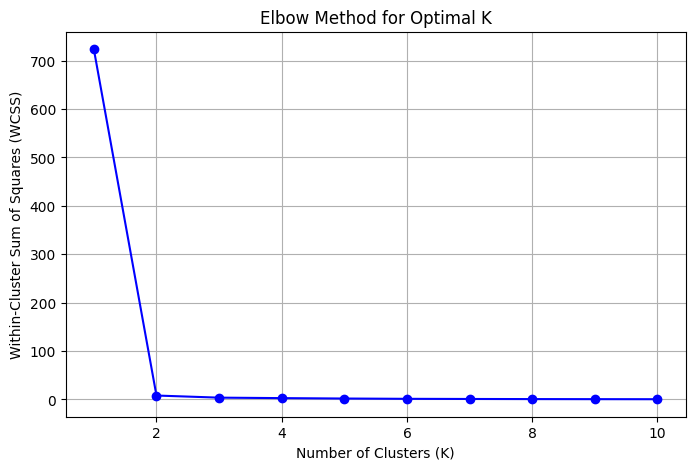

In [150]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming features is a NumPy array where each row represents a burst with two columns (half-width, peak)

# Initialize an empty list to store the WCSS values for different values of K
wcss = []

# Define a range of values for K (number of clusters)
k_values = range(1, 11)  # You can adjust the range as needed

# Calculate WCSS for each value of K
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features[:,0].reshape(-1,1))
    wcss.append(kmeans.inertia_)
# Calculate the change in slope between consecutive WCSS values
slope_changes = [abs(wcss[i] - wcss[i - 1] )for i in range(1, len(wcss))]

# Find the index with the maximum slope change
optimal_k_index = slope_changes.index(max(slope_changes)) + 1  # Adding 1 because of zero-based indexing

# Optimal K is the K value at the inflection point with the maximum slope change
optimal_k = k_values[optimal_k_index]
# Plot the WCSS values to determine the elbow point
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


In [151]:
print(optimal_k)

2


In [152]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming features is a NumPy array where each row represents a burst with two columns (half-width, peak)
# Assuming you have already determined the optimal number of clusters, e.g., optimal_k

# Initialize and fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k)
cluster_labels = kmeans.fit_predict(features)
print(cluster_labels)
# Now, cluster_labels contains the cluster assignments for each burst

# Create a dictionary to store features and their indices for each cluster
cluster_data = {cluster_id: {'features': [], 'indices': []} for cluster_id in range(optimal_k)}

# Assign features and their indices to their respective clusters
for i, label in enumerate(cluster_labels):
    cluster_data[label]['features'].append(features[i])
    cluster_data[label]['indices'].append(i)

# Access features and indices for a specific cluster (e.g., cluster 0)
cluster_0_features = np.array(cluster_data[0]['features'])
cluster_0_indices = np.array(cluster_data[0]['indices'])

cluster_1_indices = np.array(cluster_data[1]['indices'])


[0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1
 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0]


/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


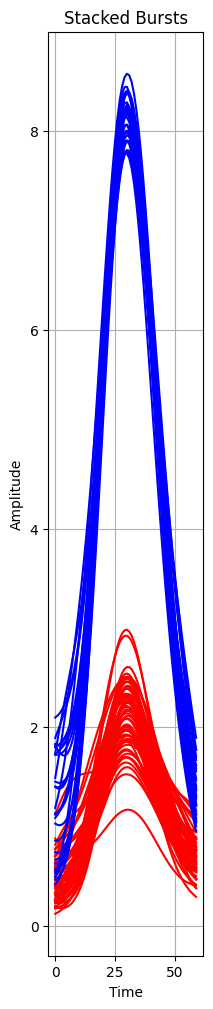

In [153]:
plt.figure(figsize=(2, 12))  # Adjust the figure size as needed

for row in stacked_bursts[cluster_0_indices,:]:
    plt.plot(row, c='red')
for row in stacked_bursts[cluster_1_indices,:]:
    plt.plot(row, c='blue')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Stacked Bursts')
plt.grid(True)
plt.show()
    

    

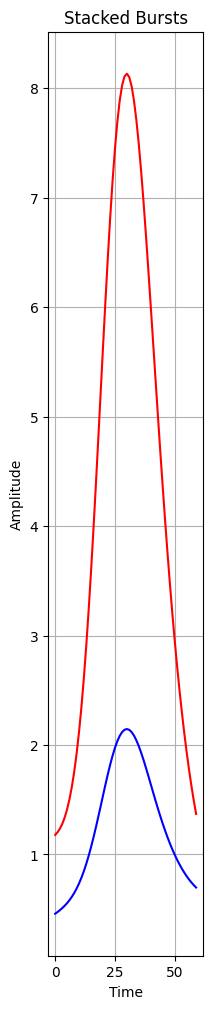

In [129]:
template1 = np.mean(stacked_bursts[cluster_0_indices,:],axis =0)
template2 = np.mean(stacked_bursts[cluster_1_indices,:], axis =0)
plt.figure(figsize=(2, 12))
plt.plot(template2,c='blue')
plt.plot(template1,c='red')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Stacked Bursts')
plt.grid(True)
plt.show()

In [96]:
print(stacked_bursts[1,:].shape)

(60,)


In [70]:
template= np.mean(stacked_bursts,axis=0)

In [71]:
template.shape

(60,)

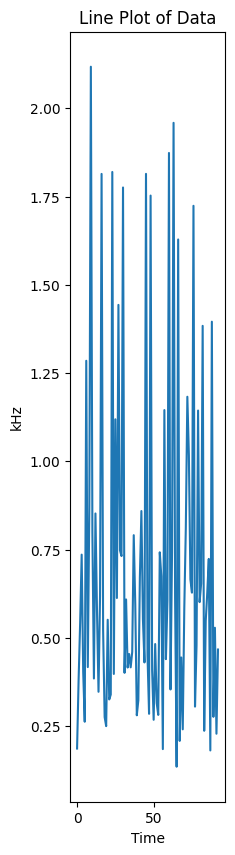

In [94]:
plt.figure(figsize=(2,10))
plt.plot(stacked_bursts[:,1])

plt.xlabel('Time')
plt.ylabel('kHz')
plt.title('Line Plot of Data')
plt.show()

In [46]:
#generating the template, which is the average among the bursts
num_burst = len(list_of_burst)
point_on_burst = len(list_of_burst[0])
sum_of_burst = [0]*point_on_burst
for burst in list_of_burst:
    for x in range(point_on_burst):
        sum_of_burst[x] += burst[x]
    
template= [total / num_burst for total in sum_of_burst]

print(sum_of_burst)

[]


[]


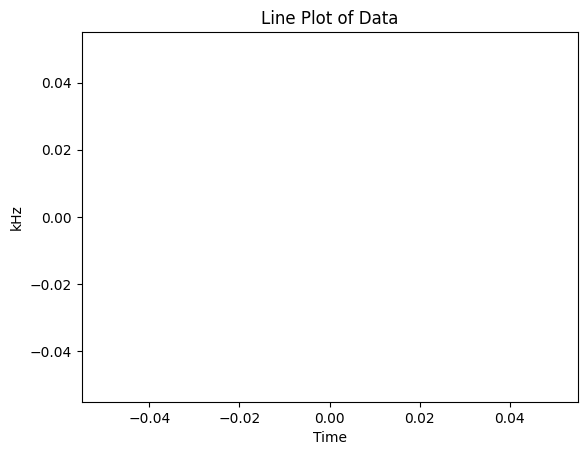

In [29]:
print(template)
plt.plot(template)
plt.xlabel('Time')
plt.ylabel('kHz')
plt.title('Line Plot of Data')
plt.show()

In [73]:
#find the pearson correlation coefficient between each individual burst and the template
pcc=[]
for burst in stacked_bursts:
    pcc.append(np.corrcoef(burst, template)[0, 1])

print(pcc)
len(pcc)

[0.9811687442363042, 0.9924953730364483, 0.9737480481829015, 0.9981821012910462, 0.9935630727118674, 0.9969497053579862, 0.9949437268390571, 0.994657254447506, 0.9716986051532776, 0.98682520771067, 0.9762936564243434, 0.9827806482039423, 0.8215154284193051, 0.9978316117891758, 0.9901113509616984, 0.9931701890604472, 0.9989759298674454, 0.9731227870446661, 0.9924152910510103, 0.9843295627279234, 0.9945491765862221, 0.8898300502598954, 0.9907774071541761, 0.9873253669975185, 0.9476437623404925, 0.9992689177942619, 0.9847434640742546, 0.9936953965701546, 0.9333506139793665, 0.9719770736291936, 0.9933461478967496, 0.9958869044325224, 0.9947124565243898, 0.9938751344765182, 0.9994277775607615, 0.9972175936492907, 0.9960701042068807, 0.9571203420944774, 0.9978035255661907, 0.9982218278764547, 0.971747228219105, 0.9836670955214247, 0.999718059020716, 0.9894144552760892, 0.9863371549654633, 0.9965431792318551, 0.9752449508519412, 0.996064979282056, 0.9978807793212772, 0.9958302651386608, 0.985

93

/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-package

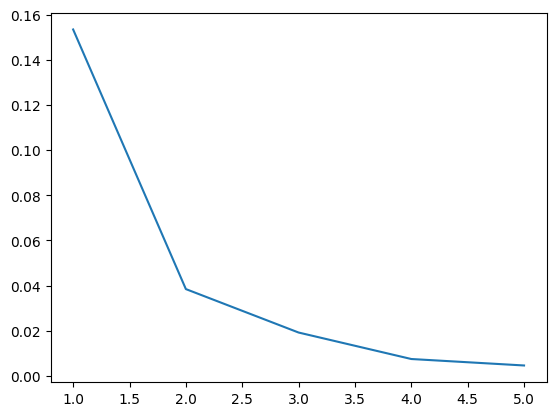

In [74]:
import numpy as np
from sklearn.cluster import KMeans



# Reshape the data to fit the KMeans input format
X = np.array(pcc).reshape(-1, 1)
distortions =[]
for i in range(1,6):
    # Create a KMeans instance with 4 clusters
    kmeans = KMeans(n_clusters=i)

    # Fit the model to the data
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.plot([1,2,3,4,5],distortions)





In [75]:
kmeans = KMeans(n_clusters=2)

# Fit the model to the data
kmeans.fit(X)
# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

print("Cluster Labels:", cluster_labels)
print("Centroids:", centroids)

Cluster Labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Centroids: [[0.98536299]
 [0.74291072]]


/home/mmp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
#find the average PCC
sum = 0
for value in pcc:
    sum+=value
average_pcc= sum/(len(pcc))

print(average_pcc)

0.9924153618242861
